# In this notebook, frame properties are assigned to entities detected in the Entity identification section
 

In [1]:
from collections import defaultdict
import nltk
import os
import pickle
import stanza
import pandas as pd
from  tqdm.notebook import tqdm


nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

def pickle_file(file_name, file_to_dump):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path +  fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, 'wb') as fp:
        pickle.dump(file_to_dump, fp)

def load_pickle(file_name):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path + fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, "rb") as input_file:
        return pickle.load(input_file)
    
def read_event_df(event_name):
    data_url = fr"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_{event_name}_clean.csv"
    directory_path = os.getcwd() + "/../../../../" + data_url 
    event_df = pd.read_csv(directory_path, index_col=0)
    event_df.reset_index(drop=True, inplace=True)
    print(f'loaded {event_df.shape[0]} tweets!')
    return event_df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikodemicek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Encoding the vocabulary of the event dataset

Pre-requisite files:
     
     -event_df = event dataset (specifically, frame identification corpus)
     
The word embeddings created in this step will be used to determine the similarity of words in the vocabulary to frames' seed words

In [2]:
def get_bag_of_words(df_col):
    
    df_col = df_col[~df_col.isnull()] 
    df_col = df_col.apply(lambda x: x.split(' '))     
    bag_of_words = set([word for tweet_words in df_col for word in tweet_words if len(word)>1])

    return list(bag_of_words)


def embed_words(bag_of_words):
    from time import time
    from sentence_transformers import SentenceTransformer
    #sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')

    print(f'there are {len(bag_of_words)} entities to be encoded')
    t0 = time()
    word_embeddings = sbert_model.encode(bag_of_words)
    print(f'Training embeddings took {time()-t0} seconds')
    return word_embeddings

In [39]:
event_df = read_event_df('greece')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('greece_word_embeddings',model)

loaded 137462 tweets!
there are 50060 entities to be encoded
Training embeddings took 819.3549072742462 seconds


In [40]:
event_df = read_event_df('channel')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('channel_word_embeddings',model)

loaded 173758 tweets!
there are 49807 entities to be encoded
Training embeddings took 686.8561251163483 seconds


In [41]:
event_df = read_event_df('tigray')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('tigray_word_embeddings',model)

loaded 42853 tweets!
there are 25973 entities to be encoded
Training embeddings took 368.55032300949097 seconds


In [42]:
event_df = read_event_df('rohingya')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('rohingya_word_embeddings',model)

loaded 29432 tweets!
there are 19460 entities to be encoded
Training embeddings took 271.6321425437927 seconds


## 2. Assign frame properties to words in the corpus

Pre-requisite files:
     
     - event_df (or the bag_of_words file from the previous step)
     - model - embedded words for similarity comparison
     - frame_properties - dictionary of frames with seed words as values
     
The resulting word_properties file is a dictionary of all words in the event dataset and their similarity to the frame, calculated as the highest similarity out of all frame's seed words

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

# run this if  [event]_word_properties does not exist yet
def assign_word_frame_properties(tweet_words,model,frame_properties):
    #print('assigning frame properties to words from tweets...')
    word_properties = defaultdict(dict)
    #for i in tqdm(tweets_corpus):
     #   tweet_words = [word.lower() for word in i.split() if word not in stop_words and len(word)>1]
    for word in tqdm(tweet_words):
        #print(word)
        word = lemma.lemmatize(word)
        property_list = []
        for prop in list(frame_properties.keys()):
            try:
                weights = [cosine_similarity(model[word].reshape(1,-1), model[seed].reshape(1,-1)) for seed in frame_properties[prop]]
                #print(weights)
                if max(weights)>0.7:
                    word_properties[word][prop] = max(weights)
                    #print(word,prop, max(weights))
            except KeyError:
                pass
    return  word_properties   

def get_word_properties(event_name):
    event_df = read_event_df(event_name)
    model = load_pickle(f'{event_name}_word_embeddings')
    frame_properties = load_pickle(f'{event_name}_final_frames')
    tqdm.pandas()
    word_properties = assign_word_frame_properties(get_bag_of_words(event_df['frame_identification_corpus']),model,frame_properties)
    pickle_file(f'{event_name}_word_properties', word_properties)
    return word_properties


In [37]:
print(len(get_bag_of_words(event_df['frame_identification_corpus'])))

19460


In [44]:
word_properties = get_word_properties('greece')

loaded 137462 tweets!


  0%|          | 0/50060 [00:00<?, ?it/s]

In [44]:
word_properties = get_word_properties('channel')

loaded 173758 tweets!


  0%|          | 0/49807 [00:00<?, ?it/s]

migrating migration [[0.88768446]]
_policy_ political [[0.8814256]]
safe relief [[0.9999999]]
immigrationist migration [[0.8865917]]
moneypouting economic [[0.7564436]]
governmenthelp political [[0.79958344]]
taxpayer political [[1.]]
cheap economic [[0.71476716]]
millionthat economic [[0.82245827]]
benefitsof relief [[0.79120445]]
controlling relief [[0.9027218]]
death relief [[1.0000002]]
milion economic [[0.7020351]]
govs political [[0.7039176]]
legalaid political [[0.80805147]]
invasion migration [[0.99999976]]
lawrs political [[0.7870535]]
workplace integration [[0.70832807]]
control relief [[0.9999998]]
safed relief [[0.82585686]]
migrationis migration [[0.88970995]]
taxation political [[0.7064189]]
rulesthe political [[0.76248854]]
migrantsmuggling migration [[0.71247315]]
jobbing integration [[0.82644653]]
immigranti migration [[0.78017104]]
police criminal [[1.]]
balloting political [[0.7698539]]
hoteld settlement [[0.86422694]]
migration migration [[1.]]
economicus economic [

homelife settlement [[0.7576828]]
constabulary criminal [[0.7824513]]
womanship integration [[0.7558506]]
womenwho integration [[0.70071065]]
lawfully political [[0.7487897]]
migraters migration [[0.7744212]]
houseswhat settlement [[0.86449003]]
immigrantswhat migration [[0.7999125]]
invaded migration [[0.8477535]]
governance political [[0.7575999]]
thousandsof economic [[0.7216173]]
enters migration [[0.9556446]]
hotelroom settlement [[0.778319]]
housebuilding settlement [[0.80899465]]
racisty criminal [[0.9571376]]
assistance relief [[0.8042054]]
invasiontheyare migration [[0.7987894]]
supporting relief [[0.87207025]]
invades migration [[0.7891025]]
price economic [[0.8860371]]
welcomer settlement [[0.8734595]]
homeand settlement [[0.86760914]]
hundred economic [[0.8058317]]
gdp economic [[0.7094035]]
migrates migration [[0.8384861]]
supportedsince relief [[0.73425657]]
policefederale criminal [[0.7237575]]
regulate relief [[0.7076205]]
secure relief [[0.7163975]]
welcome settlement 

pooreat economic [[0.80437297]]


In [66]:
word_properties = get_word_properties('tigray')

loaded 42853 tweets!


  0%|          | 0/25973 [00:00<?, ?it/s]

safe relief [[0.9999999]]
foodaid vulnerability [[0.72788787]]
food vulnerability [[1.0000001]]
criminalls suffering [[0.89332414]]
forcing suffering [[0.8955414]]
devastation destruction [[0.79399246]]
death destruction [[1.0000002]]
govs military/political [[0.7039176]]
rapist suffering [[0.8622086]]
helpfully humanitarian [[0.7018627]]
young humanitarian [[0.79638445]]
raping suffering [[0.9999999]]
workplace humanitarian [[0.7058704]]
abuse suffering [[1.0000001]]
peaceand relief [[0.90500647]]
housenegros humanitarian [[0.73479944]]
pained suffering [[0.7016398]]
childrean humanitarian [[0.741577]]
force suffering [[0.7265045]]
killedy destruction [[0.8171182]]
innocently relief [[0.8209959]]
lootingdestroyed destruction [[0.8082856]]
civiliansve military/political [[0.7065296]]
cleaned destruction [[0.7387638]]
genocideif destruction [[0.9313007]]
mankind humanitarian [[0.8471978]]
anguish suffering [[0.74852014]]
massacreed destruction [[0.9889041]]
governmen military/political 

deathsquad destruction [[0.7253058]]
peaceful relief [[0.8125431]]
murder destruction [[0.74369705]]
looting destruction [[0.9999998]]
hungerproject vulnerability [[0.7506347]]
assistance humanitarian [[1.]]
healthfor relief [[0.791961]]
supportet humanitarian [[0.71928054]]
supporting humanitarian [[0.87207025]]
wellness relief [[0.75859034]]
foodno vulnerability [[0.7810718]]
hungered vulnerability [[0.85441065]]
meal vulnerability [[0.777336]]
kill destruction [[0.9999999]]
safeguarded relief [[0.82896173]]
secure relief [[0.8351866]]
terrorist suffering [[0.9999999]]
infringement suffering [[0.72495085]]
nutritional vulnerability [[0.71502054]]
attackes suffering [[0.8942981]]
teen humanitarian [[0.7251133]]
famine vulnerability [[1.0000001]]
unsecurity relief [[0.70214736]]
corpse destruction [[0.71203]]
woman humanitarian [[1.0000002]]
starvation vulnerability [[0.9999997]]
violation suffering [[1.0000001]]
civiliance military/political [[0.9192831]]
violated suffering [[0.871473

In [45]:
word_properties = get_word_properties('rohingya')

loaded 29432 tweets!


  0%|          | 0/19460 [00:00<?, ?it/s]

aidnews humanitarian [[0.743534]]
safer relief [[0.7996616]]
safe relief [[0.9999999]]
suppressive relief [[0.80473673]]
militaryjuntas military [[0.77847785]]
assistancen humanitarian [[0.84237677]]
terroristjunta violence [[0.78194475]]
humankind humanitarian [[0.81432664]]
foodstuff relief [[0.7563698]]
emergency humanitarian [[0.9999999]]
supplied humanitarian [[0.7351692]]
perished violence [[0.8439814]]
food relief [[1.0000001]]
safety relief [[1.]]
detention political [[0.8385208]]
bomber military [[0.7064595]]
bomber violence [[0.7271303]]
terrorrists violence [[0.7472366]]
humanity humanitarian [[1.0000002]]
employee humanitarian [[0.72894144]]
civillans political [[0.8597629]]
familues humanitarian [[0.73086625]]
forceably political [[0.769391]]
militarycoup military [[0.74256885]]
dismantled violence [[0.71724653]]
forcing political [[0.9999998]]
invaded violence [[0.70255125]]
sheltersdestroyed relief [[0.74438024]]
massacred violence [[0.87423897]]
attacking violence [[0.9

forcedly political [[0.8968275]]
protected relief [[0.8937449]]
humanitarianresponse humanitarian [[0.85770684]]
assistace humanitarian [[0.74100816]]
suicide violence [[0.70417076]]
burn violence [[0.90810674]]
childern humanitarian [[0.7296082]]
unlawfully political [[0.7372249]]
fatality violence [[0.72892964]]
charitable humanitarian [[0.726617]]
genocider violence [[0.92366886]]
help humanitarian [[1.0000002]]
airstrikes violence [[1.]]
familytries humanitarian [[0.7394931]]
nationalisam political [[0.8006421]]
plane military [[0.7771756]]
jailed political [[0.7022327]]
criminal violence [[0.8101381]]
healthy relief [[0.78384656]]
govenment political [[0.7084557]]
support humanitarian [[1.0000001]]
crackdown violence [[1.]]
imprisoned political [[0.7548237]]
devastatingblaze violence [[0.76543486]]
devastatingly violence [[0.8913071]]
securing relief [[0.7886114]]
govts political [[0.9206618]]
demise violence [[0.7831942]]
illegally political [[0.9114258]]
torching violence [[0.72

In [31]:
word_properties = load_pickle('channel_word_properties')
word_properties

defaultdict(dict,
            {'migrating': {'migration': array([[0.88768446]], dtype=float32)},
             '_policy_': {'political': array([[0.8814256]], dtype=float32)},
             'safe': {'security': array([[0.9999999]], dtype=float32)},
             'immigrationist': {'migration': array([[0.8865917]], dtype=float32)},
             'moneypouting': {'economic': array([[0.7564436]], dtype=float32)},
             'governmenthelp': {'political': array([[0.79958344]], dtype=float32)},
             'partisanship': {'political': array([[0.7044751]], dtype=float32)},
             'authoritatively': {'political': array([[0.72525716]], dtype=float32)},
             'millionthat': {'economic': array([[0.82245827]], dtype=float32)},
             'controlling': {'security': array([[0.9027218]], dtype=float32)},
             'death': {'violence': array([[1.0000002]], dtype=float32)},
             'milion': {'economic': array([[0.7020351]], dtype=float32)},
             'prevent': {'security'

## 3. Assigning frames to entities

Pre-requisite files:

     - event_df = event dataset
     - [event]_tagged_tweets = tagged tweets object containing dependency parse trees
     - event_ents = list of event entities (we are going to use top 10 only)
     - frame_properties = dictionary of frames with seed words as values
     - word_properties = dictionary of all words in the event dataset and their similarity to frames

In [7]:
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
def get_ent_head(entity):
    if len(word_tokenize(entity))>1:
        entity_doc = en_nlp(entity)
        #the root of NP has value 0. Since head is only one and stored in a list, we pick item [0]
        return [word.text for tweet_ent in entity_doc.sentences for word in tweet_ent.words if word.head == 0][0]
    else:
        return entity


en_nlp = stanza.Pipeline("en",  
                          tokenize_pretokenized=False,
                          processors = "tokenize,pos,lemma,depparse",
                          verbose=False)

In [5]:
def assign_frame_properties(event_df, tagged_tweets,event_ents,frame_properties,word_properties):
    # import these modules 
    from collections import defaultdict
    from nltk.stem import WordNetLemmatizer 
    import numpy as np
    
    def find_framed_words(ent_to_add, ent_to_compare,frame_properties,word_properties):
        #add frame by word choice 
        rep_head = get_ent_head(ent_to_compare)
        add_dataframe_entry(ent_to_add,rep_head,frame_properties,word_properties)

        #find all dependencies of the entity head
        for related in range(len(ent_words)):
            ent_word = ent_words[related][1].lower()
            if rep_head == ent_word:
                related_word = lemma.lemmatize(ent_words[related][2].lower())
                #add frame by labeling
                add_dataframe_entry(ent_to_add,related_word,frame_properties,word_properties) 
            elif rep_head == ent_words[related][2].lower() and ent_words[related][2].lower() in stop_words:
                add_dataframe_entry(ent_to_add,ent_word,frame_properties,word_properties) 
                
                
    
    def add_dataframe_entry(ent,framing_word,frame_properties,word_properties):
        #append a dataframe row with the entity and its assignment to a frame
        ent_frames['entity'].append(ent)
        ent_frames['framing_word'].append(framing_word)
        ent_frames['date'].append(event_df['date'][tweet_id])
        ent_frames['tweet_id'].append(event_df['id'][tweet_id])
        
        for frame_property in list(frame_properties.keys()):
            
            #append the weight towards a frame to the entity row
            try:
                frame_weight = word_properties[framing_word][frame_property][0][0]
                ent_frames[frame_property].append(frame_weight)
                
            except KeyError:
                ent_frames[frame_property].append(np.NaN)
 
                        
    lemma = WordNetLemmatizer() 
    ent_frames = defaultdict(list)
    if event_name == 'channel':
        #in channel, uk and english were manually merged
        entities = list(event_ents.keys())[:9] + ['refugees','migrants']
    else:
        entities = list(event_ents.keys())[:10] + ['refugees','migrants']

    framed_words = pd.DataFrame(columns=['word','date','framing_word','tweet_id',list(frame_properties.keys())])
    event_df[['date','time']] = event_df['created_at'].str.split(' ',expand=True)
    
    # lowercase parsing corpus and remove extra whitespace so it is formatted in the same way as entities
    event_df['clean_parsing_corpus'] = event_df['parsing_corpus'].apply(lambda x: re.sub('[^0-9a-zA-Z]+', ' ', x.lower()))
    event_df['clean_parsing_corpus'] = event_df['clean_parsing_corpus'].apply(lambda x: " ".join(x.split()))
    
    for tweet_id in tqdm(event_df.index):
        clean_tweet = event_df['clean_parsing_corpus'][tweet_id]
        ent_words = [[word.id, word.text,sent.words[word.head-1].text] for sent in tagged_tweets[tweet_id].sentences for word in sent.words]
 
        for ent in entities:
            #check if the entity is in the tweet
            if f' {ent} ' in f' {clean_tweet} ':
                loop_switch = False
                #if the entity is in the tweet, check if there is a merged entity that contains entity text
                for merged_ent in event_ents[ent]:
                    if f' {ent} ' in f' {merged_ent} ' and f' {merged_ent} ' in f' {clean_tweet} ':
                        # if trie, use merged_ent to find framed words. Since the list is sorted, loop is escaped once true
                        find_framed_words(ent,merged_ent,frame_properties,word_properties)
                        loop_switch=True
                        break
                    #elif f' {ent} ' in f' {clean_tweet} and f' {merged_ent} ' in f' {clean_tweet} ':
                # if there isn't a merged entity that contains entity text, use the main entity to find framed words    
                if loop_switch==False:
                    find_framed_words(ent,ent,frame_properties,word_properties)
            else:
                #if the main entity isn't in the tweet, look over its merged entities and add frames if it is contained
                for merged_ent in event_ents[ent]:
                    if f' {merged_ent} ' in f' {clean_tweet} ':
                        find_framed_words(ent,merged_ent,frame_properties,word_properties)
                        break
    
    return ent_frames
                
        

In [50]:
def get_framed_entities(event_name):
    event_df = read_event_df(event_name)
    tagged_tweets = load_pickle(f'{event_name}_tagged_tweets')
    event_ents = load_pickle(f'{event_name}_what_merged')
    frame_properties = load_pickle(f'{event_name}_final_frames')
    word_properties = load_pickle(f'{event_name}_word_properties')

    #sort the values in merged entities dictionary so the longest are first
    for key,value in event_ents.items():
        event_ents[key] = sorted(value,key=len, reverse=True)

    ent_frames = assign_frame_properties(event_df,tagged_tweets,event_ents)

    framed_entities = pd.DataFrame.from_dict(ent_frames)

    pickle_file(f'{event_name}_framed_entities',framed_entities)
    return framed_entities

In [ ]:
framed_entities = get_framed_entities('greece')

In [ ]:
framed_entities = get_framed_entities('channel')

In [ ]:
framed_entities = get_framed_entities('tigray')

In [ ]:
framed_entities = get_framed_entities('rohingya')

## 4. Frame heatmaps - finding frames ratios for entities

Pre-requisite files:

    - framed_entities = dataframe of all framing instances in an event dataset

In [47]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

def aggregate_frames(framed_entities):
    frame_copy = framed_entities.copy()
    aggr_frames = frame_copy.groupby(['entity'],as_index=True,sort=False).count()    
    aggr_frames.drop(['framing_word','date','tweet_id'],axis=1,inplace=True)
    aggr_frames = aggr_frames.T
    aggr_frames =  aggr_frames.groupby(aggr_frames.index)[aggr_frames.columns].first()

    aggr_frames_pct = aggr_frames / aggr_frames.sum()

    return aggr_frames, aggr_frames_pct



def frame_heatmap(aggr_frames,event_name):
    cols = list(aggr_frames.columns)
    cols.remove('refugees')
    cols.remove('migrants')
    aggr_frames = aggr_frames[['refugees', 'migrants'] + cols]
    aggr_frames = aggr_frames.T

    
    
    
    #aggr_frames.reindex(['refugees', 'migrants'] + cols)
    cbar_kws = {"shrink":.5, 'extend':'both'} 
    plt.figure(figsize = (16,10))
    ax = sns.heatmap(aggr_frames, cmap='Blues',  fmt='g')
    #ax.set_xlabel('X LABEL')    
    loc, labels = plt.xticks()

    ax.set_xticklabels(labels, rotation=90)
    ax.xaxis.set_ticks_position('top') 
    ax.set(ylabel=None)
    figure = ax.get_figure()    
    #figure.savefig(f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_heatmap.png', 
                   #dpi=400,
                   #bbox_inches="tight")



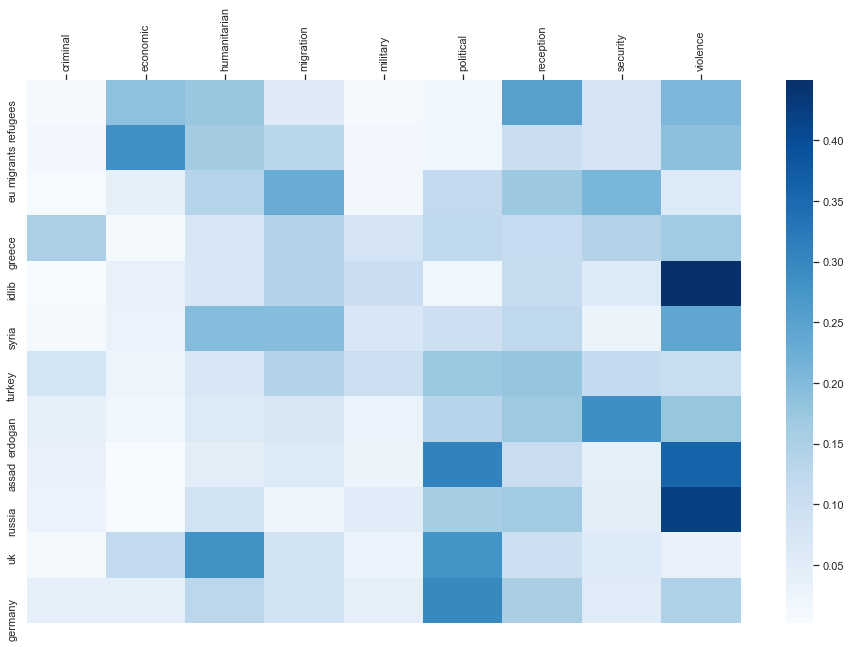

In [48]:
framed_entities = load_pickle('greece_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)

frame_heatmap(aggr_frames_pct,'greece')
#aggr_frames

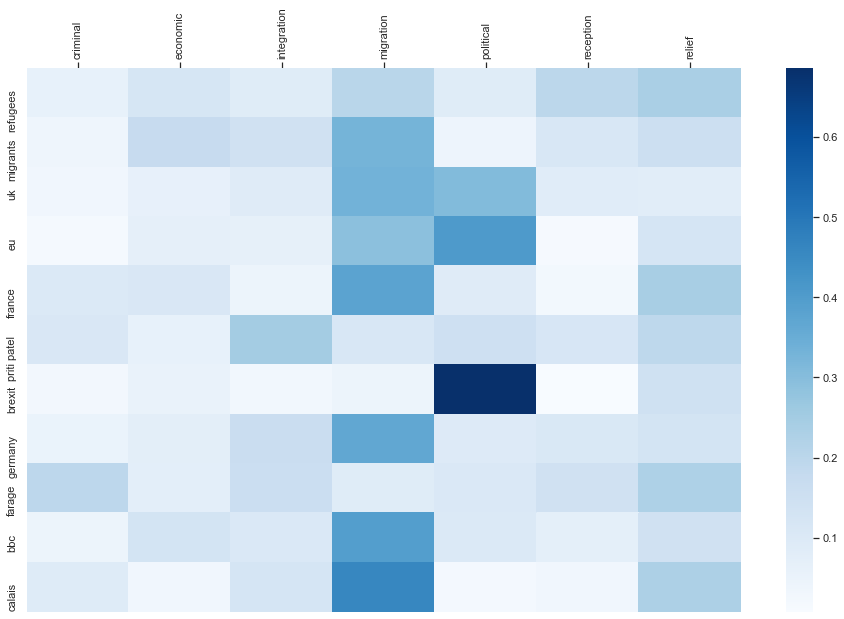

In [54]:
framed_entities = load_pickle('channel_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)
frame_heatmap(aggr_frames_pct,'channel')


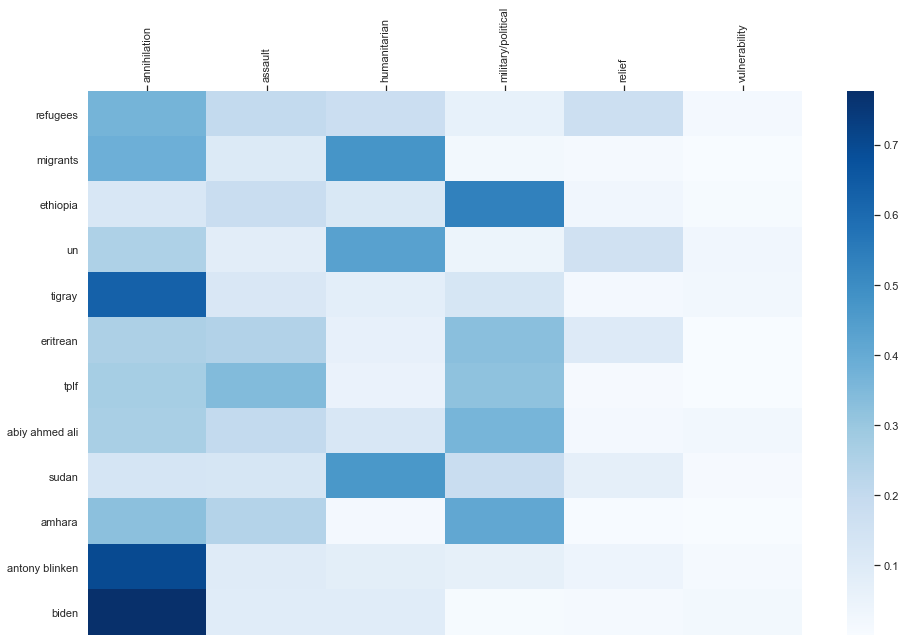

In [55]:
framed_entities = load_pickle('tigray_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)
frame_heatmap(aggr_frames_pct,'tigray')

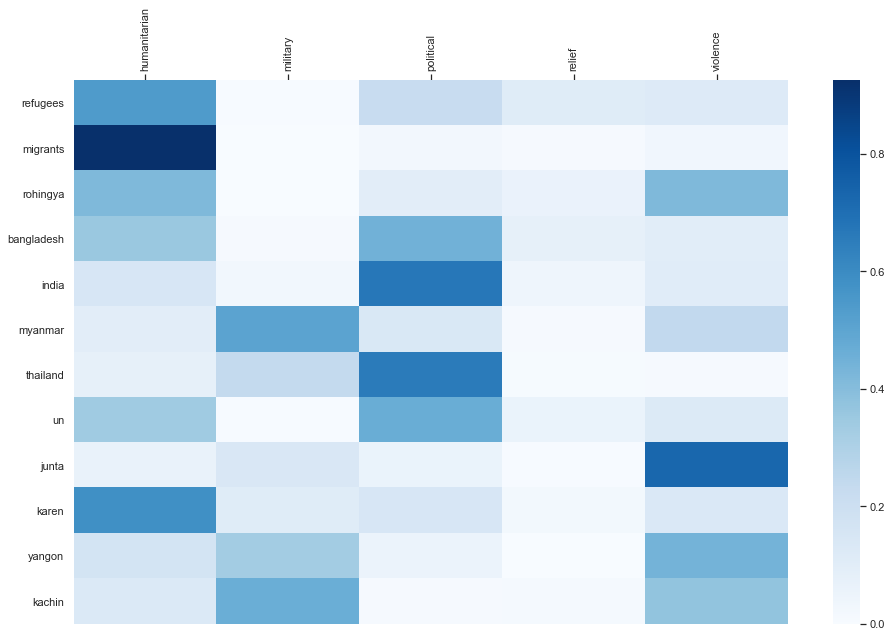

In [56]:
framed_entities = load_pickle('rohingya_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)
frame_heatmap(aggr_frames_pct,'rohingya')

## 5. Find frames timeline - frame variations over weeks

Pre-requisite files:

     - event_ents = list of entities (top 10 selected)
     - framed_entities = dataframe of all framing instances in an event dataset

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Set3')

# assigning the same color for a frame if it occurs across events
list_of_frames = 'humanitarian economic political security military criminal reception assault migration violence integration relief'.split(' ')
list_of_frames2 = 'xx xx military/political xx xx xx xx assault xx annihilation vulnerability'.split(' ')
colormap = {list_of_frames[i]:cmap(i,bytes=False) for i in range(len(list_of_frames))}
colormap = {**colormap,  **{list_of_frames2[i]:cmap(i,bytes=False) for i in range(len(list_of_frames2))}}

In [327]:
def weekly_frames(entity,framed_entities,event_name):
    import matplotlib.patheffects as pe
    import numpy as np

    merged_frames = framed_entities.copy()
    merged_frames = merged_frames[merged_frames['entity'] == entity]
    #print(merged_frames)
    merged_frames['week'] = pd.to_datetime(merged_frames['date'], format='%Y-%m-%d').dt.strftime('%W')

    aggr_frames = merged_frames.groupby(['entity','week'],as_index=False).count()
    
    aggr_frames.drop(['entity','framing_word','date','tweet_id'],axis=1,inplace=True)
    
    aggr_frames = aggr_frames.set_index('week').T

    counts= aggr_frames.sum()
    aggr_frames = aggr_frames / aggr_frames.sum()
    
    tps = aggr_frames.T.div(aggr_frames.T.sum(1), axis=0)
    
    
    ax = tps.plot(kind='bar', stacked=True,color = colormap)#color = colors.values())#)
    ax2 = counts.plot(kind='line',lw=2,c='b',secondary_y=True,path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()])
    ax2.grid(False)
    ax.set_xlabel('week', fontsize=14)
    #ax.set(ylabel='% Frame proportion')
    #ax2.set(ylabel='Total frame instances')
    handles, labels = ax.get_legend_handles_labels()
    
    legend = ax.legend(reversed(handles), reversed(labels),loc='center left', bbox_to_anchor=(1.2, 0.5))
    #ax.legend(reversed(handles), reversed(labels),loc='center left', bbox_to_anchor=(1.2, 0.5))
    ax.set(ylabel=None)
    ax.tick_params(axis='both', labelsize=14)
    ax2.tick_params(axis='both', labelsize=14)
    #ax.set_title(f'{entity}', fontdict={'fontsize': 14, 'fontweight': 'medium'})
     
    
    def export_legend(legend, filename=f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_legend.png', expand=[-5,-5,5,5]):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent()
        bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
        bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, dpi="figure", bbox_inches=bbox)

    export_legend(legend)
    ax.get_legend().remove()
    figure = ax.get_figure()   
    figure.savefig(f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_{entity}_frames.png', 
                   dpi=600,
                   bbox_inches="tight")

    return aggr_frames



['refugees', 'migrants', 'turkey', 'greece', 'eu', 'syria', 'erdogan', 'russia', 'idlib', 'uk', 'assad', 'germany']


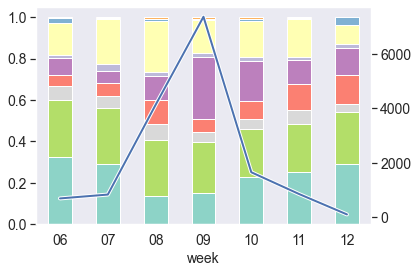

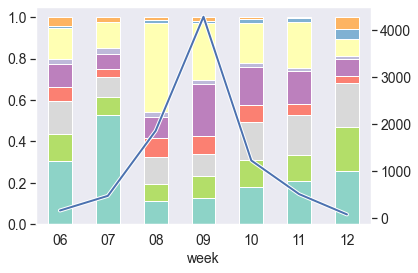

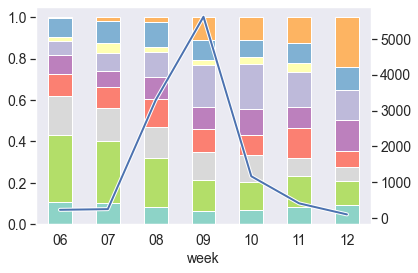

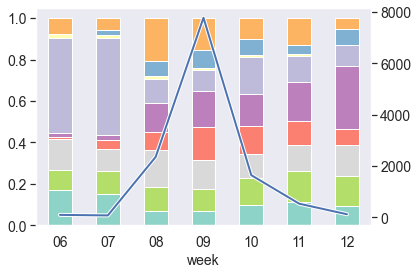

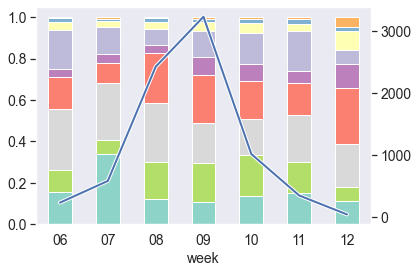

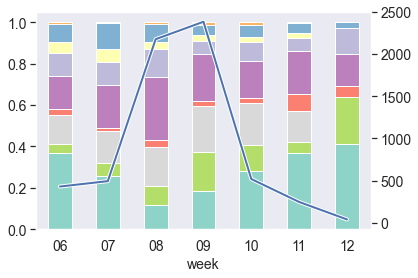

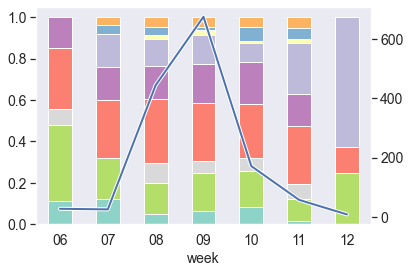

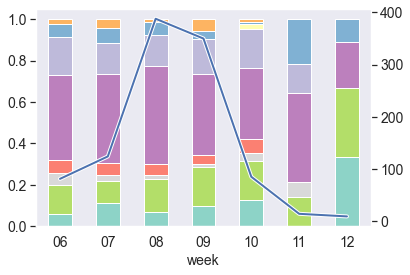

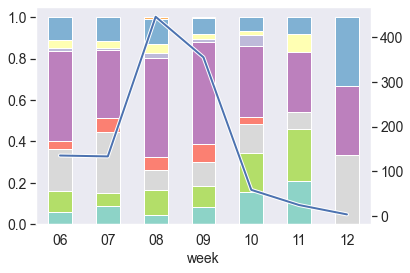

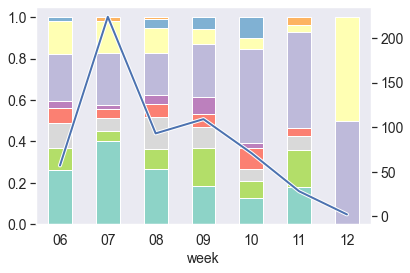

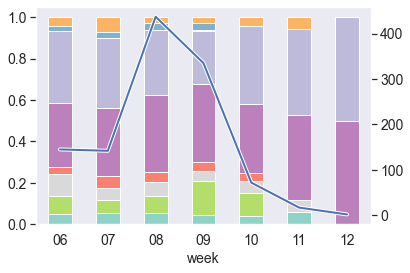

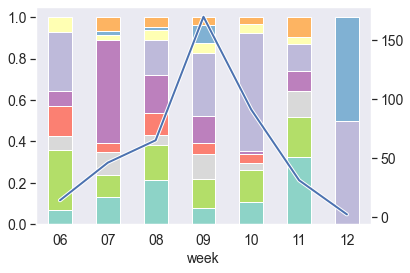

In [328]:
event_name = 'greece'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:10]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)

['refugees', 'migrants', 'uk', 'france', 'eu', 'priti patel', 'farage', 'germany', 'bbc', 'calais', 'brexit']


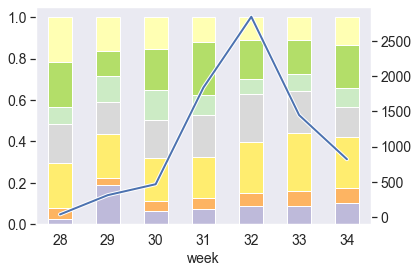

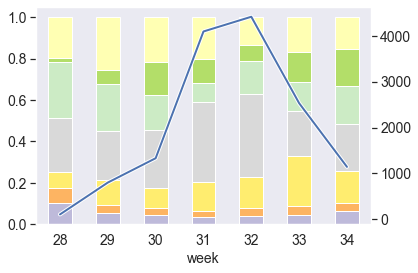

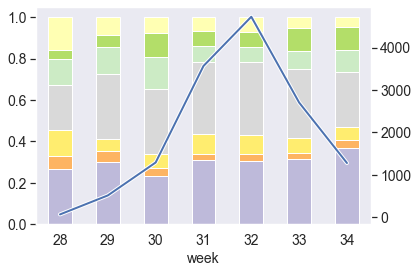

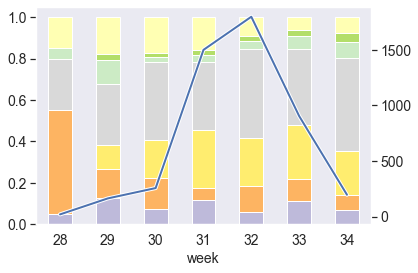

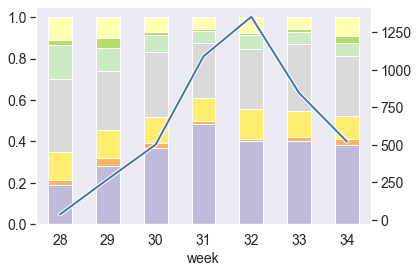

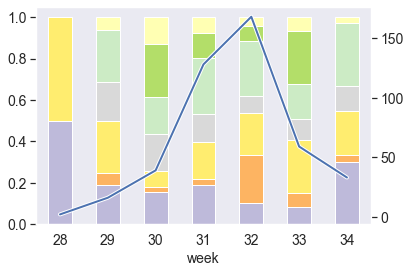

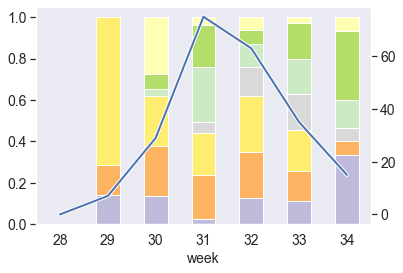

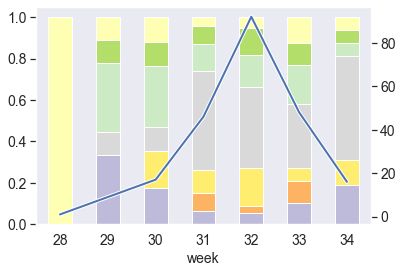

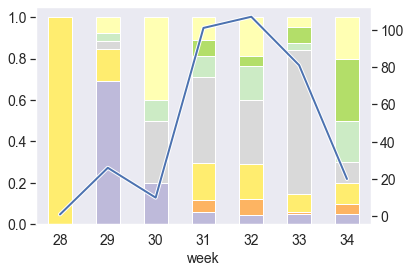

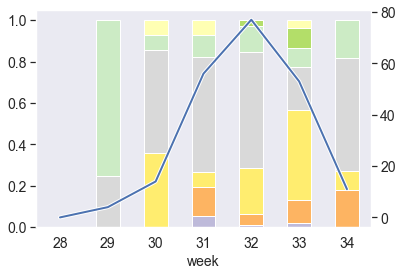

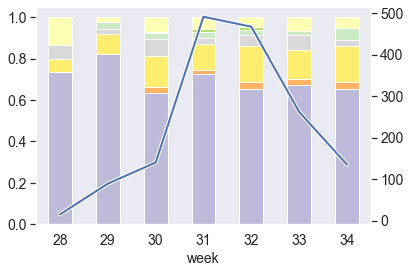

In [329]:
event_name = 'channel'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:9]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)

['refugees', 'migrants', 'eritrean', 'ethiopia', 'tigray', 'sudan', 'un', 'tplf', 'biden', 'antony blinken', 'abiy ahmed ali', 'amhara']


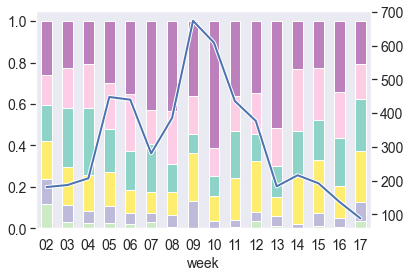

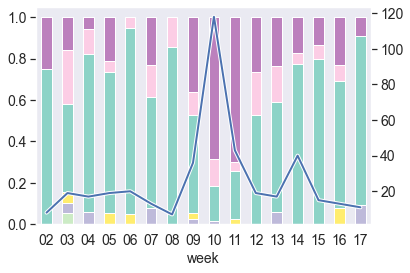

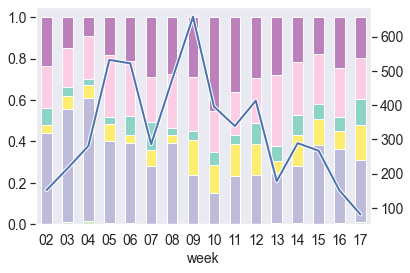

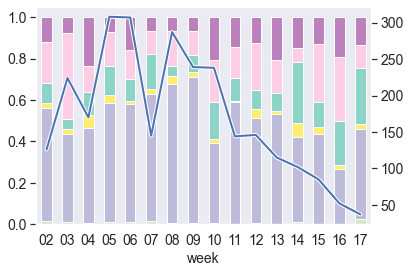

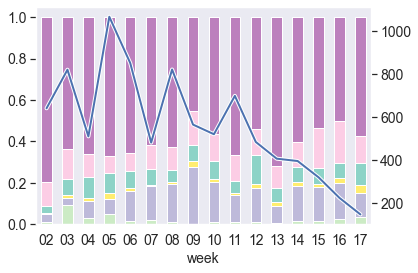

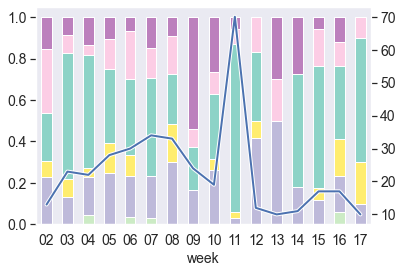

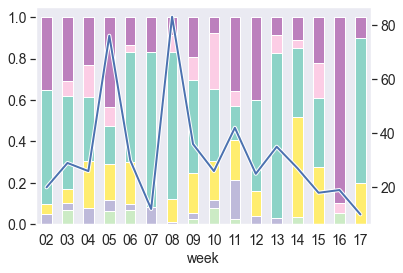

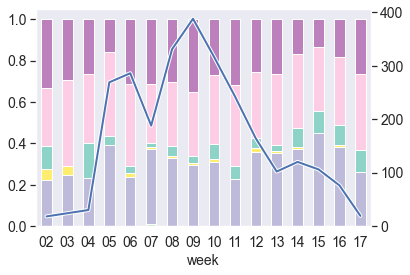

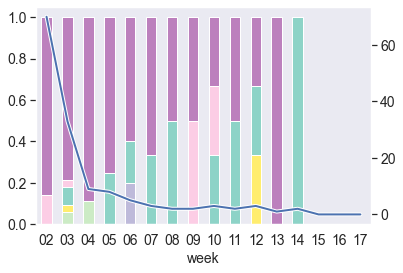

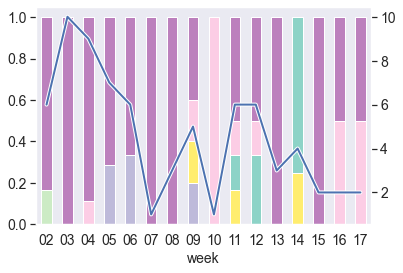

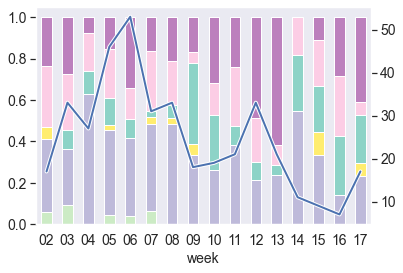

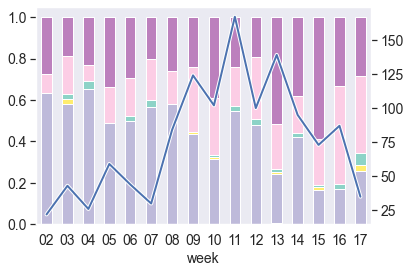

In [330]:
event_name = 'tigray'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:10]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)

['refugees', 'migrants', 'myanmar', 'rohingya', 'bangladesh', 'thailand', 'india', 'un', 'karen', 'junta', 'yangon', 'kachin']


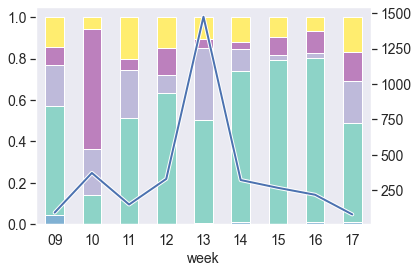

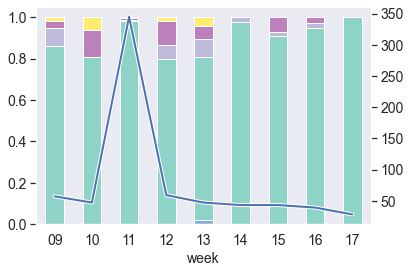

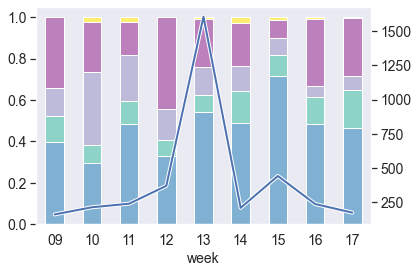

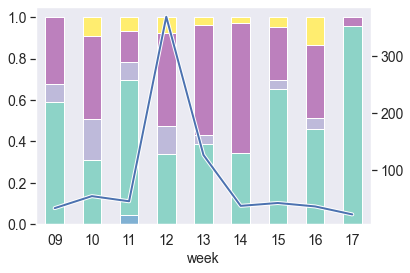

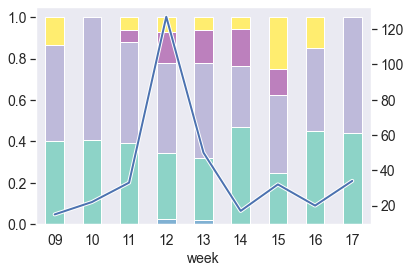

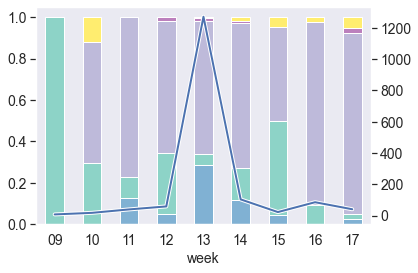

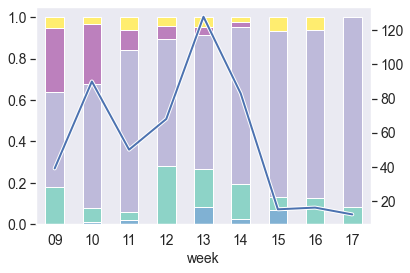

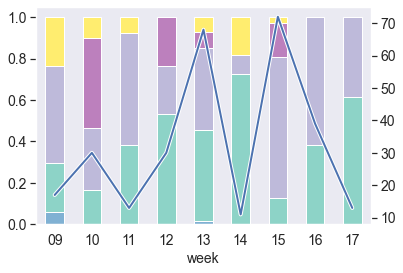

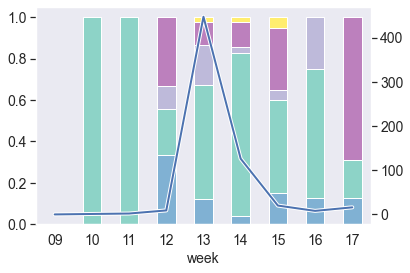

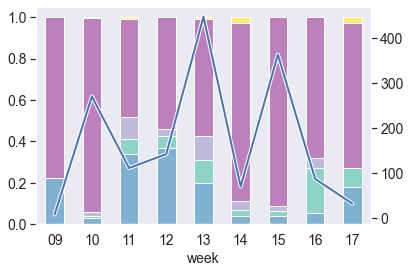

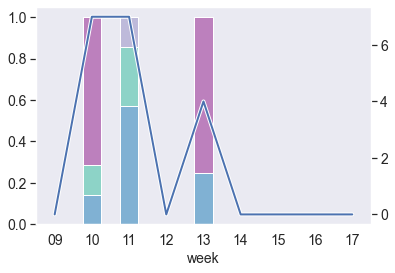

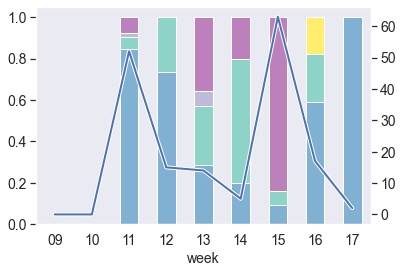

In [331]:
event_name = 'rohingya'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:10]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)